# Daily Weather Forecast

This notebook gets the weather forecast for the city requested and shows the forecast and the temperature graph.

## The input

This cell will be replaced by the place parameter specified when you run the notebook using notebook execution:

In [1]:
place="Minneapolis, MN"

## Convert the location to longitude and latitude

In this section, we use the [geopy](https://geopy.readthedocs.io/en/stable/) library to get the latitude and longitude of the city from Open Street Map. 

In [2]:
from geopy.geocoders import Nominatim

In [3]:
geolocator = Nominatim(user_agent="sagemaker test app")
location = geolocator.geocode(place)

In [4]:
if location is None:
    raise ValueError("Unknown place name: {}".format(place))

In [5]:
latitude = location.latitude
longitude = location.longitude

print("{} is at lat/long {}, {}".format(place, latitude, longitude))

Minneapolis, MN is at lat/long 44.9772995, -93.2654692


## Use the NWS API to retrieve the forecast

The National Weather Service has an [API](https://www.weather.gov/documentation/services-web-api) to retrieving forecasts for any lat/long combo in the United States. 

Getting the forecast from an arbitrary point is a two-stage process. First, you call the `points` endpoint to find the forecasts for the specified point. The result gives you URLs for hourly and twice-daily forecasts that cover that point. You retrieve those to get the actual forecast.

All the results are in JSON, so they're easy to consume.

In [6]:
info_url = "https://api.weather.gov/points/{0:.4f},{1:.4f}".format(latitude,longitude)
info_url

'https://api.weather.gov/points/44.9773,-93.2655'

We use the `requests` library to retrieve the JSON and then save it to a pandas dataframe.

In [7]:
import requests
import json
import pandas as pd
import numpy as np

In [8]:
response = requests.get(info_url)
# If the response was successful, no Exception will be raised
response.raise_for_status()

In [9]:
info = json.loads(response.text)
forecastHourly_url = info["properties"]["forecastHourly"]
forecast_url = info["properties"]["forecast"]

In [10]:
def get_forecast(url):
    response = requests.get(url)
    response.raise_for_status()

    forecast_data = json.loads(response.text)
    forecast = pd.DataFrame(forecast_data["properties"]["periods"])
    forecast["startTime"] = pd.to_datetime(forecast["startTime"])
    forecast["endTime"] = pd.to_datetime(forecast["endTime"])
    return forecast

hourly_forecast = get_forecast(forecastHourly_url)
daily_forecast = get_forecast(forecast_url)

## Forecast for the next 24 hours

In [11]:
today = hourly_forecast[:24][["startTime","temperature","windSpeed", "windDirection", "shortForecast"]]
today = today.rename(columns={"temperature": "Temperature", "shortForecast": "Forecast"})
today.insert(0, "Date", today["startTime"].dt.strftime("%b %d"))
today.insert(1, "Time", today["startTime"].dt.strftime("%H:%M"))
today.insert(4, "Wind", today[["windSpeed", "windDirection"]].agg(' '.join, axis=1 ))
today = today.drop(["startTime", "windSpeed", "windDirection"], axis="columns")
today.set_index(['Date', 'Time'])

Temperature        Wind       Forecast
Date   Time                                         
May 21 17:00           69  10 mph SSE  Mostly Cloudy
       18:00           69  10 mph SSE  Mostly Cloudy
       19:00           69  10 mph SSE  Mostly Cloudy
       20:00           69   5 mph SSE  Mostly Cloudy
       21:00           67   5 mph SSE  Mostly Cloudy
       22:00           65   5 mph SSE  Mostly Cloudy
       23:00           64   5 mph SSE  Mostly Cloudy
May 22 00:00           63   5 mph SSE  Mostly Cloudy
       01:00           62   5 mph SSE  Mostly Cloudy
       02:00           61    5 mph SE  Mostly Cloudy
       03:00           61    5 mph SE  Mostly Cloudy
       04:00           60   5 mph SSE  Mostly Cloudy
       05:00           59    5 mph SE  Mostly Cloudy
       06:00           59    5 mph SE  Mostly Cloudy
       07:00           60    5 mph SE  Mostly Cloudy
       08:00           62    5 mph SE  Mostly Cloudy
       09:00           65   10 mph SE  Mostly Cloudy
       10:00           67   10 mph SE  Mostly Cloudy
       11:00           69  10 mph SSE  Mostly Cloudy
       12:00           70  10 mph SSE  Mostly Cloudy
       13:00           72   10 mph SE  Mostly Cloudy
       14:00           73  10 mph SSE  Mostly Cloudy
       15:00           74   10 mph SE  Mostly Cloudy
       16:00           74  10 mph SSE  Mostly Cloudy

## Forecast for the next week

In [12]:
week = daily_forecast[["name","temperature","windSpeed", "windDirection", "shortForecast"]]
week = week.rename(columns={"name": "When", "temperature": "Temperature", "shortForecast": "Forecast"})
week.insert(4, "Wind", week[["windSpeed", "windDirection"]].agg(' '.join, axis=1 ))
week = week.drop(["windSpeed", "windDirection"], axis="columns")
week = week.style.hide_index()
week

When,Temperature,Wind,Forecast
This Afternoon,71,10 mph SSE,Mostly Cloudy
Tonight,59,5 to 10 mph SSE,Mostly Cloudy
Friday,74,5 to 10 mph SE,Mostly Cloudy
Friday Night,63,5 to 10 mph ESE,Chance Showers And Thunderstorms
Saturday,76,5 to 10 mph SE,Chance Showers And Thunderstorms then Showers And Thunderstorms Likely
Saturday Night,64,0 to 5 mph SE,Chance Showers And Thunderstorms then Mostly Cloudy
Sunday,82,5 to 10 mph SSE,Chance Showers And Thunderstorms
Sunday Night,62,5 mph SW,Showers And Thunderstorms Likely then Chance Showers And Thunderstorms
Memorial Day,76,5 mph WNW,Chance Showers And Thunderstorms
Monday Night,59,0 to 5 mph WNW,Chance Showers And Thunderstorms then Mostly Cloudy


## A chart of temperatures for the next 7 days

We use the [Altair](https://altair-viz.github.io/index.html) charting library to render the hourly predicted temperatures for the next week.

In [13]:
import altair as alt

In [14]:
nights_df=hourly_forecast.assign(new=hourly_forecast.isDaytime.diff().ne(0).cumsum()).groupby(["isDaytime", "new"]).agg({"startTime": min, "endTime": max}).reset_index()
nights_df=nights_df[nights_df["isDaytime"]==False]
nights=alt.Chart(nights_df).mark_rect(color="#9E9CC9").encode(x="startTime:T", x2="endTime:T")

In [15]:
scaleMin = np.min(hourly_forecast["temperature"])
scaleMin = int(scaleMin * 0.9)
scaleMin = scaleMin - (scaleMin % 5)

scaleMax = np.max(hourly_forecast["temperature"])
scaleMax = int(scaleMax * 1.1)
scaleMax = scaleMax + (5 - (scaleMax % 5))
domain = (scaleMin, scaleMax)

In [16]:
temps = (alt.Chart(hourly_forecast, title="7-day Temperature Forecast for {}".format(place)).
         mark_line().
         encode(x=alt.X("startTime", title="Date"),
                y=alt.Y("temperature", title="Temperature (°F)",scale=alt.Scale(domain=domain))).
         properties(width=700, height=300))

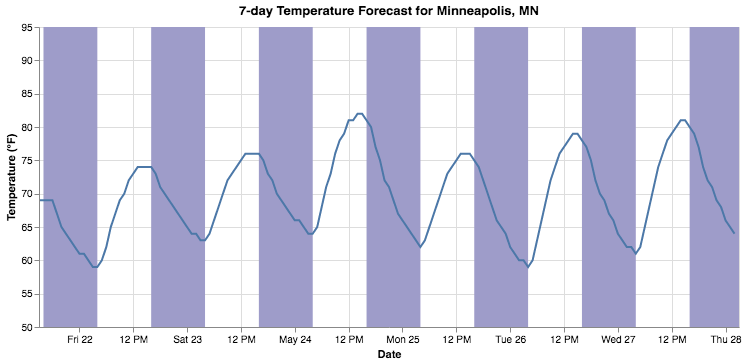

In [19]:
nights + temps

## Save the results with scrapbook

We use [scrapbook](https://github.com/nteract/scrapbook) to save particular results of this run so that they can be retrieved later by reading the notebook.

This will let us take the data from multiple runs of the notebook and compare it.

In [19]:
import scrapbook as sb

sb.glue("place", place)
sb.glue("hourly_forecast", hourly_forecast.to_json())
sb.glue("daily_forecast", daily_forecast.to_json())